In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
from scipy.stats import mode

# Suppress warnings and set random seed
warnings.filterwarnings('ignore')
np.random.seed(42)

# Load datasets
train_df = pd.read_csv('/content/mnist_train.csv')
test_df = pd.read_csv('/content/mnist_test.csv')

# Separate features and labels
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

In [17]:
knn_params = {'n_neighbors': [3, 7, 11], 'weights': ['distance']}

grid_search_knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=2, n_jobs=-1)

X_train_sample = X_train.sample(n=6000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

# Train model
grid_search_knn.fit(X_train_sample, y_train_sample)

best_n_neighbors = grid_search_knn.best_params_['n_neighbors']
best_weight = grid_search_knn.best_params_['weights']
best_score = grid_search_knn.best_score_

# Print results
print(f"Best KNN Parameters: n_neighbors={best_n_neighbors}, weights='{best_weight}'")
print(f" Best Cross-Validation Accuracy: {best_score:.3f}")

Best KNN Parameters: n_neighbors=3, weights='distance'
 Best Cross-Validation Accuracy: 0.925


In [18]:
log_params = {'C': [0.1, 1, 10]}

# Reduce cross-validation folds (cv=2)
grid_search_log = GridSearchCV(LogisticRegression(max_iter=200), log_params, cv=2, n_jobs=-1)

X_train_sample = X_train.sample(n=6000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

# Train the model
grid_search_log.fit(X_train_sample, y_train_sample)

best_C = grid_search_log.best_params_['C']
best_score_log = grid_search_log.best_score_

# Print results
print(f"Best Logistic Regression Parameter: C={best_C}")
print(f"Best Cross-Validation Accuracy: {best_score_log:.3f}")

Best Logistic Regression Parameter: C=0.1
Best Cross-Validation Accuracy: 0.837


In [23]:
kmeans_params = {
    'n_init': [5, 10],
    'max_iter': [100, 200],
    'algorithm': ['lloyd', 'elkan']
}

# Custom scoring function (Silhouette Score)
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

# Use GridSearchCV with the new scoring metric
grid_search_kmeans = GridSearchCV(KMeans(n_clusters=10, random_state=42),
                                  param_grid=kmeans_params, cv=2,
                                  n_jobs=-1, scoring=silhouette_scorer)

# Use a smaller dataset sample
X_train_sample = X_train.sample(n=2000, random_state=42)

# Train the model
grid_search_kmeans.fit(X_train_sample)

# Extract best parameters
best_n_init = grid_search_kmeans.best_params_['n_init']
best_max_iter = grid_search_kmeans.best_params_['max_iter']
best_algorithm = grid_search_kmeans.best_params_['algorithm']
best_score_kmeans = grid_search_kmeans.best_score_

In [25]:
# Define and train models, then evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=100),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'K-Means Clustering': KMeans(n_clusters=10, random_state=42)
}

In [26]:
# Initialize results dictionary
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # If K-Means, adjust cluster labels to match actual labels
    if name == "K-Means Clustering":
        from scipy.stats import mode
        labels = np.zeros_like(y_pred)
        for i in range(10):  # There are 10 clusters
            mask = (y_pred == i)
            labels[mask] = mode(y_test[mask])[0]
        y_pred = labels

    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    results[name] = accuracy  # Store in results dictionary

    print(f'\n{name} Accuracy: {accuracy:.3f}')
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


Logistic Regression Accuracy: 0.925
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.97      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.93      0.93      0.93       982
           5       0.90      0.87      0.89       892
           6       0.94      0.95      0.95       958
           7       0.93      0.93      0.93      1028
           8       0.87      0.89      0.88       974
           9       0.91      0.91      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000

Confusion Matrix:
[[ 963    0    0    3    1    3    4    4    2    0]
 [   0 1112    4    2    0    1    3    2   11    0]
 [   3   10  926   15    6    4   15    8   42    3]
 [  


The best-performing model is KNN with an accuracy of 0.969


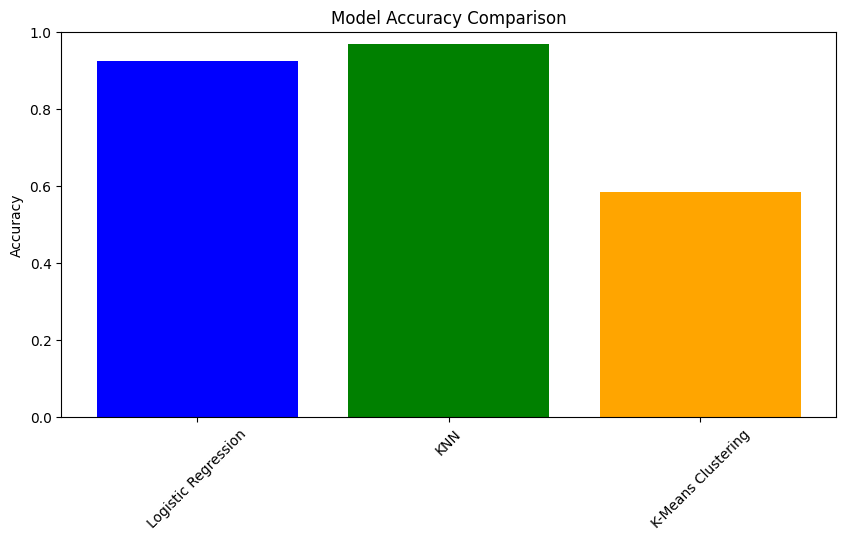

In [27]:
# Plot model accuracy comparison
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), results.values(), color=['blue', 'green', 'orange'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
best_model = max(results, key=results.get)
best_accuracy = results[best_model]
print(f"\nThe best-performing model is {best_model} with an accuracy of {best_accuracy:.3f}")
plt.show()